In [ ]:
# Sample usage of capytaine slant solver
# Unknown why the .py version much slower than the more direct version
# Theory: symmetry axis does not propogate in multi-step mesh generation, so symmetry-leveraging solver doesn't work?

import numpy as np
import math
import matplotlib.pyplot as plt
import capytaine as cpt
import sys
import os
sys.path.append(os.path.relpath('../'))
from capytaine_generator import CapytaineSlantSolver

In [2]:
css = CapytaineSlantSolver(False, False, False, False, False)
css_mesh = CapytaineSlantSolver(True, False, False, False, False)
def compute_cpt_slant(config, t_densities, face_units = 150, f_densities = None, solver = css):
  respack = solver.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, face_units,
                                    config["h"], config["m0"], config["rho"], reps = 1, f_densities = f_densities)
  return respack[0]
rho = 1023

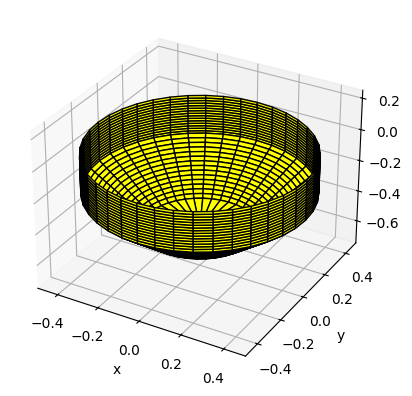

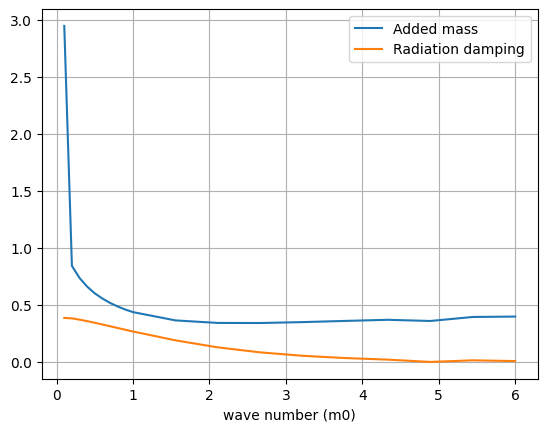

In [3]:
h = 1.001
a = [0.25, 0.5]
d_in = [0.5, 0.5]
d_out = [0.5, 0.25]
heaving = [1, 1]
m0_nums = np.concatenate((np.linspace(0.1, 0.9, 9), np.linspace(1, 6, 10)))

configs = [{"h": h, "a": a, "d_in" : d_in, "d_out" : d_out, "heaving" : heaving, "rho" : rho, "m0" : m0} for m0 in m0_nums]
_ = compute_cpt_slant(configs[0], [40, 40], f_densities = [1, 14, 15], solver = css_mesh)
results = [compute_cpt_slant(config, [40, 40], f_densities = [1, 14, 15]) for config in configs]
for result in results:
  result.body.name = "mesh"
  result.body.mesh.name = "mesh"
dataset = cpt.io.xarray.assemble_dataset(results)

omega = dataset['omega']
A = dataset['added_mass'].sel(radiating_dof='Heave',influenced_dof='Heave')
B = dataset['radiation_damping'].sel(radiating_dof='Heave', influenced_dof='Heave')
A_nondim = h**3 / (rho * np.pi * a[-1]**3) * A
B_nondim = h**3 / (omega * rho * np.pi * a[-1]**3) * B

# Plot results
plt.figure()
plt.plot(m0_nums, A_nondim, label="Added mass")
plt.plot( m0_nums, B_nondim, label="Radiation damping")
plt.xlabel('wave number (m0)')
plt.grid()
plt.legend()
plt.show()

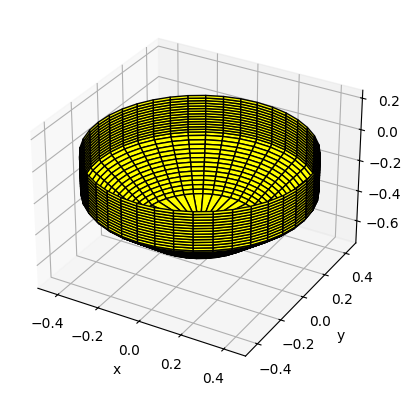

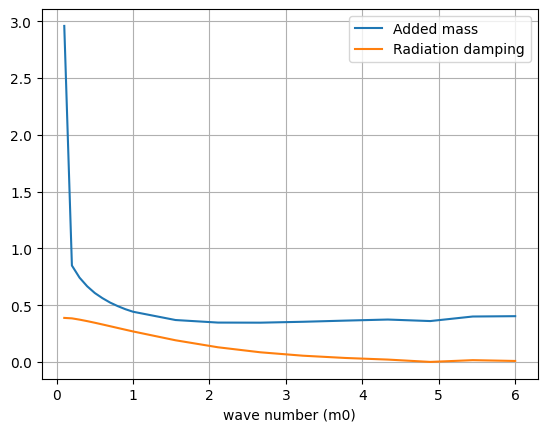

In [8]:
# Profile of the axisymmetric body
def shape(z):
    if z >= -0.25:
        return 0.5
    elif z < -0.25 and z >= -0.499:
        return z + 0.75
    elif z < -0.4999 and z <= -0.5:
        return 5000*z+2500 #approximating a the bottom surface

# Generate the mesh and display it with VTK.
buoy = cpt.FloatingBody(
    mesh=cpt.AxialSymmetricMesh.from_profile(shape, z_range=np.linspace(-0.5, 0, 30), nphi=40)
)
buoy.add_translation_dof(name="Heave")
buoy.show_matplotlib()

# Set up problems
rho = 1023
g = 9.81
problems = [cpt.RadiationProblem(body=buoy, radiating_dof='Heave', wavenumber = m0, water_depth = h, rho = 1023)
            for m0 in m0_nums]

# Solve the problems using the axial symmetry
solver = cpt.BEMSolver(engine=cpt.HierarchicalToeplitzMatrixEngine())
results = [solver.solve(pb) for pb in problems]
dataset = cpt.io.xarray.assemble_dataset(results)

omega = dataset['omega']
A = dataset['added_mass'].sel(radiating_dof='Heave',influenced_dof='Heave')
B = dataset['radiation_damping'].sel(radiating_dof='Heave', influenced_dof='Heave')
A_nondim = h**3 / (rho * np.pi * 0.5**3) * A                # 0.5 is the radius of the slant object
B_nondim = h**3 / (omega * rho * np.pi * 0.5**3) * B        # 0.5 is the radius of the slant object
# Plot results
plt.figure()
plt.plot(m0_nums, A_nondim, label="Added mass")
plt.plot( m0_nums, B_nondim, label="Radiation damping")
plt.xlabel('wave number (m0)')
plt.grid()
plt.legend()
plt.show()

In [5]:
# # Mini Bicylinder
# h = 1.001
# d = [0.25, 0.125]
# a = [0.125, 0.25]
# heaving = [1, 1]

# # Small Bicylinder
# h = 1.001
# d = [0.5, 0.25]
# a = [0.5, 1.0]
# heaving = [1, 1]

# # Big Bicylinder
# h = 1.001
# d = [0.75, 0.5]
# a = [0.5, 0.75]
# heaving = [1, 1]

# # Mini Tricylinder
# h = 2.001
# d = [1.0, 0.5, 0.25]
# a = [0.25, 0.5, 1.0]
# heaving =[1, 1, 1]

# # Small Tricylinder
# h = 20.0
# d = [15, 10, 5]
# a = [5, 10, 15]
# heaving =[1, 1, 1]

# # Big Tricylinder
# h = 25.0
# d = [20, 15, 10]
# a = [10, 15, 20]
# heaving =[1, 1, 1]

# Some Bicylinder
# h = 1.001
# d = [0.75, 0.25]
# a = [0.25, 0.75]
# heaving = [1, 1]



In [6]:
# print(A_nondim)
# print(B_nondim)

# # Extract values from NumPy arrays
# flat_list1 = [x.item() for x in A_nondim]
# flat_list2 = [x.item() for x in B_nondim]

# # Convert to MATLAB-style string
# matlab_list1 = "pyCapytaine_mu_nondim = [" + " ".join(map(str, flat_list1)) + "];"
# matlab_list2 = "pyCapytaine_lambda_nondim = [" + " ".join(map(str, flat_list2)) + "];"

# # Print MATLAB code
# print(matlab_list1)
# print(matlab_list2)